# Case Study: Predicting Obesity Prevalence in US Counties

**Objective:** This notebook demonstrates how to use Data Commons to build a linear regression model predicting the prevalence of obesity in US counties.

**Background:** Obesity prevalence is known to correlate with various health and socio-economic factors [[1]](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3198075/)[[2]](https://www.ncbi.nlm.nih.gov/pubmed/26562758). Data for these factors often reside in separate datasets from different government agencies:
* The Centers for Disease Control (CDC) provides health condition prevalence data (e.g., obesity, high blood pressure).
* The US Bureau of Labor Statistics (BLS) provides unemployment rates.
* The US Census Bureau provides poverty rates and population counts.

Data Commons aggregates these diverse datasets into a unified knowledge graph, simplifying data access and analysis.

**Approach:** This notebook uses Data Commons to retrieve data for the following variables for US counties in 2021:
* [Percentage of Adult Population That Is Obese](https://datacommons.org/tools/statvar#sv=Percent_Person_Obesity) (CDC) - Target variable
* [Percentage of Adult Population With High Blood Pressure](https://datacommons.org/tools/statvar#sv=Percent_Person_WithHighBloodPressure) (CDC) - Predictor variable
* [Unemployment Rate of a Population](https://datacommons.org/tools/statvar#sv=UnemploymentRate_Person) (BLS) - Predictor variable
* [Population Below Poverty Level Status in Past Year](https://datacommons.org/tools/statvar#sv=Count_Person_BelowPovertyLevelInThePast12Months) (Census) - Used to calculate poverty rate
* [Total Population](https://datacommons.org/tools/statvar#sv=Count_Person) (Census) - Used to calculate poverty rate

A linear regression model will be trained using high blood pressure prevalence, unemployment rate, and the calculated poverty rate to predict obesity prevalence.

*Note:* The US Census also provides unemployment statistics. Using BLS data here is for demonstration purposes. Comparing results using Census unemployment data could be a potential extension.

<a href="https://colab.research.google.com/github/datacommonsorg/api-python/blob/master/notebooks/analyzing_obesity_prevalence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright 2025 Google LLC.
SPDX-License-Identifier: Apache-2.0

**Notebook Version** - 2.0.0

## 1. Set up environment


### 1.1. Install libraries

Install the [datacommons-client](https://pypi.org/project/datacommons-client/) library.

In [ ]:
!pip install "datacommons-client[Pandas]" --upgrade --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 kB 2.9 MB/s eta 0:00:00


### 1.2. Import dependencies

Import required libraries for data manipulation, modeling, and plotting.


In [ ]:
import datacommons_client

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from google.colab import drive

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import json

### 1.3. Initialize Data Commons client

Initialize the client using your Data Commons API key. Obtain a key from [apikeys.datacommons.org](https://apikeys.datacommons.org/) if you don't have one.


In [ ]:
YOUR_API_KEY = "Replace this string with your API key"

dc_client = datacommons_client.DataCommonsClient(api_key=YOUR_API_KEY)

## 2. Data acquisition

Fetch statistical observations for the specified variables for all US counties for the year 2021 using the [Python Data Commons API](https://docs.datacommons.org/api/python/v2/).

In [ ]:
us_county_observations_df = dc_client.observations_dataframe(variable_dcids=[
  "Percent_Person_Obesity", # Obesity prevalence from CDC
  "Percent_Person_WithHighBloodPressure", # High blood pressure prevalence from CDC
  "UnemploymentRate_Person", # Unemployment rate from BLS
  "Count_Person_BelowPovertyLevelInThePast12Months", # Persons living below the poverty line from Census
  "Count_Person", # Total population from Census
  ], date="2021", parent_entity="country/USA", entity_type="County")

# Display the first five rows.
us_county_observations_df.head(5)

,date,entity,entity_name,variable,variable_name,value,facetId,importName,measurementMethod,observationPeriod,provenanceUrl,unit
0,2021,geoId/42077,Lehigh County,Count_Person_BelowPovertyLevelInThePast12Months,Population Below Poverty Level Status in Past ...,43982.0,1145703171,CensusACS5YearSurvey,CensusACS5yrSurvey,None,https://www.census.gov/programs-surveys/acs/da...,None
1,2021,geoId/01025,Clarke County,Count_Person_BelowPovertyLevelInThePast12Months,Population Below Poverty Level Status in Past ...,5036.0,1145703171,CensusACS5YearSurvey,CensusACS5yrSurvey,None,https://www.census.gov/programs-surveys/acs/da...,None
2,2021,geoId/12045,Gulf County,Count_Person_BelowPovertyLevelInThePast12Months,Population Below Poverty Level Status in Past ...,1214.0,1145703171,CensusACS5YearSurvey,CensusACS5yrSurvey,None,https://www.census.gov/programs-surveys/acs/da...,None
3,2021,geoId/27005,Becker County,Count_Person_BelowPovertyLevelInThePast12Months,Population Below Poverty Level Status in Past ...,3752.0,1145703171,CensusACS5YearSurvey,CensusACS5yrSurvey,None,https://www.census.gov/programs-surveys/acs/da...,None
4,2021,geoId/19121,Madison County,Count_Person_BelowPovertyLevelInThePast12Months,Population Below Poverty Level Status in Past ...,1083.0,1145703171,CensusACS5YearSurvey,CensusACS5yrSurvey,None,https://www.census.gov/programs-surveys/acs/da...,None


## 3. Data preparation

Process the fetched data for modeling:

1. **Filter:** Keep only relevant observations based on their `measurementMethod`. For CDC data, this is typically `AgeAdjustedPrevalence`. For Census, `CensusACS5YearSurvey`, and for BLS, `BLSSeasonallyUnadjusted`.
1. **Select columns:** Keep only essential columns: `entity`, `entity_name`, `variable`, `value`.
1. **Pivot:** Reshape the dataframe so each variable becomes a column, indexed by county `entity` and `entity_name`.
1. **Calculate poverty rate:** Compute the poverty rate percentage using the population count and the count of people below the poverty level.
1. **Handle missing values:** Drop rows (counties) with any missing values for the selected variables.


In [ ]:
# Filter the dataframe to only include age adjusted values
valid_methods = ['AgeAdjustedPrevalence', 'CensusACS5yrSurvey', 'CensusACS5YearSurvey', 'BLSSeasonallyUnadjusted'] # Add all the methods you want to keep

filtered_df = us_county_observations_df.loc[us_county_observations_df['measurementMethod'].isin(valid_methods), ['entity', 'entity_name', 'variable', 'value']]

# Pivot the dataframe to show our two variables as column headers
pivoted_df = filtered_df.pivot_table(index=['entity', 'entity_name'], columns='variable', values='value')

# Calculate poverty rate as the proportion of people below poverty level to total population
pivoted_df["PovertyRate"] = (
    pivoted_df["Count_Person_BelowPovertyLevelInThePast12Months"] / pivoted_df["Count_Person"]
) * 100

# Drop any null values from the dataframe
pivoted_df.dropna(inplace=True)

# Display the first five rows
pivoted_df.head(5)


,variable,Count_Person,Count_Person_BelowPovertyLevelInThePast12Months,Percent_Person_Obesity,Percent_Person_WithHighBloodPressure,UnemploymentRate_Person,PovertyRate
entity,entity_name,,,,,,
geoId/01001,Autauga County,58239.0,7847.0,38.9,37.1,2.8,13.473789
geoId/01003,Baldwin County,227131.0,20598.0,37.2,32.4,2.9,9.068775
geoId/01005,Barbour County,25259.0,5890.0,43.4,44.1,5.5,23.318421
geoId/01007,Bibb County,22412.0,3558.0,39.6,39.1,3.4,15.875424
geoId/01009,Blount County,58884.0,7720.0,37.7,35.4,2.3,13.110522


## 4. Exploratory data analysis

Visualize the relationships between the target variable (Obesity Prevalence) and the predictor variables (High Blood Pressure Prevalence, Unemployment Rate, Poverty Rate) using scatter plots. This helps assess potential correlations.


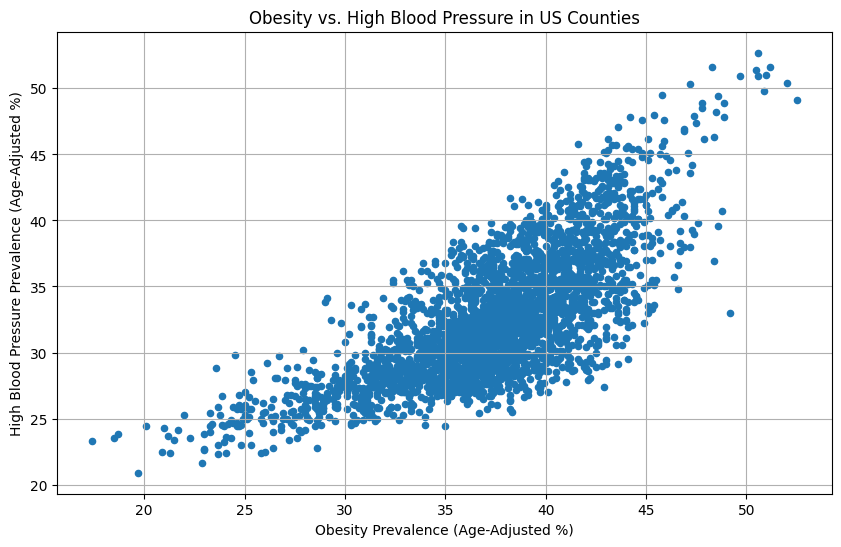

In [ ]:
pivoted_df.plot(kind='scatter',
                x='Percent_Person_Obesity',
                y='Percent_Person_WithHighBloodPressure',
                grid=True,
                figsize=(10, 6),
                title="Obesity vs. High Blood Pressure in US Counties")
plt.xlabel("Obesity Prevalence (Age-Adjusted %)")
plt.ylabel("High Blood Pressure Prevalence (Age-Adjusted %)")
plt.show()


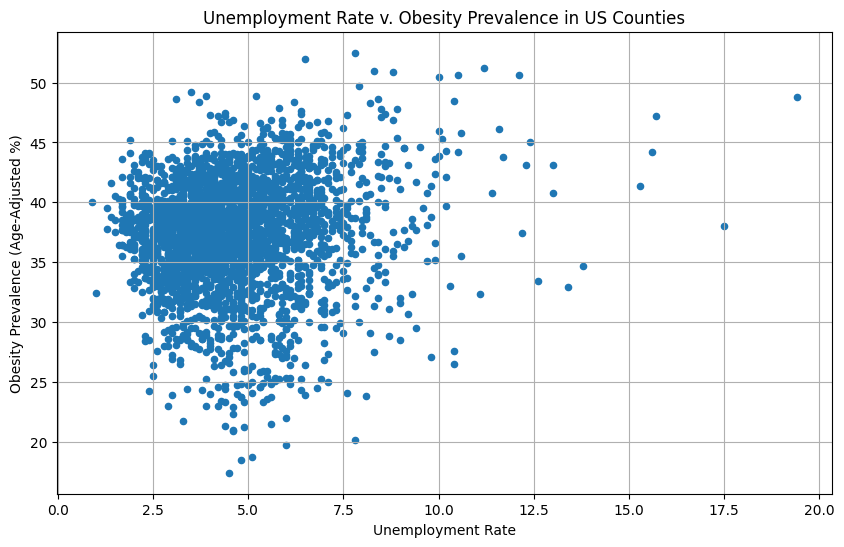

In [ ]:
# Plot Unemployment with Obesity
pivoted_df.plot(kind='scatter',
                x='UnemploymentRate_Person',
                y='Percent_Person_Obesity',
                grid=True,
                figsize=(10, 6),
                title="Unemployment Rate v. Obesity Prevalence in US Counties")
plt.xlabel("Unemployment Rate")
plt.ylabel("Obesity Prevalence (Age-Adjusted %)")
plt.show()

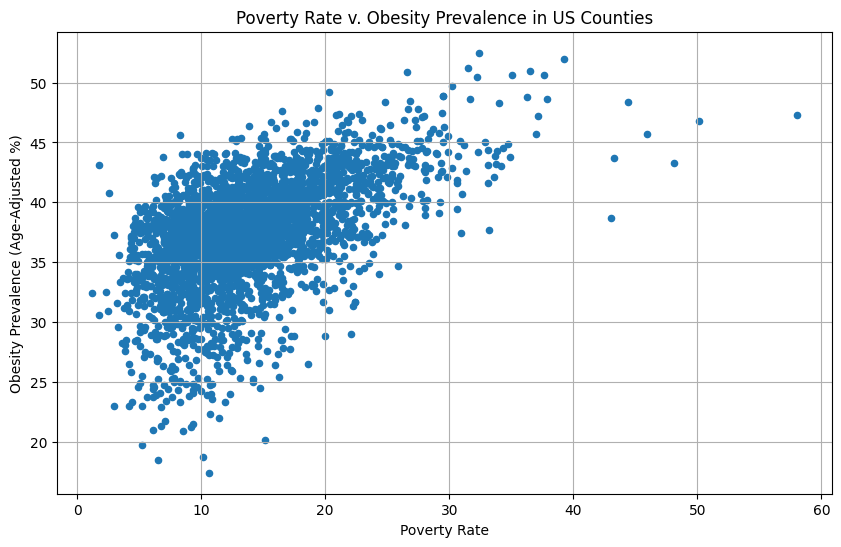

In [ ]:
# Plot PovertyRate with Obesity
pivoted_df.plot(kind='scatter',
                x='PovertyRate',
                y='Percent_Person_Obesity',
                grid=True,
                figsize=(10, 6),
                title="Poverty Rate v. Obesity Prevalence in US Counties")
plt.xlabel("Poverty Rate")
plt.ylabel("Obesity Prevalence (Age-Adjusted %)")
plt.show()


*Observation:* The scatter plots suggest positive correlations between obesity prevalence and each of the predictor variables.


## 5. Model training

Train a linear regression model to predict obesity prevalence based on the selected predictors.

The model follows the form:
<br>
$$f_\theta(x) = \theta_0 + \theta_1 (\text{high blood pressure}) + \theta_2 (\text{unemployment}) + \theta_3(\text{poverty rate})$$
<br>

### 5.1. Prepare features and target variable
Define the feature matrix `X` (predictors) and the target vector `Y` (obesity prevalence).

Let's start by creating our training and test sets. We'll then train a linear regression model using Scikit learn's [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

In [ ]:
X = pivoted_df[['Percent_Person_WithHighBloodPressure', 'UnemploymentRate_Person', 'PovertyRate']]
Y = pivoted_df[['Percent_Person_Obesity']]

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

### 5.2. Split data

Split the data into training and testing sets (80% train, 20% test).

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42) # Added random_state for reproducibility

print(f"Training set size: {x_train.shape[0]} samples")
print(f"Test set size: {x_test.shape[0]} samples")

Training set size: 2453 samples
Test set size: 614 samples


### 5.3. Train linear regression model

Instantiate and train the [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) model using the training data.



In [ ]:

model = LinearRegression(fit_intercept=True)
model.fit(x_train, y_train)

print('Model Intercept: {}'.format(model.intercept_))
print('Model Coefficients: {}'.format(model.coef_))

Model Intercept: [16.20330544]
Model Coefficients: [[ 0.66228006 -0.27859918  0.06449069]]


## 6. Model evaluation

Assess the performance of the trained model using the Mean Squared Error (MSE) metric and residual analysis.

### 6.1. Calculate Mean Squared Error (MSE)

Define a function for MSE and calculate it for both the training and test sets. Lower MSE indicates better fit.



In [ ]:
def mse(y_true, y_pred):
    """ Computes the Mean Squared Error. """
    return np.mean((y_pred - y_true) ** 2)

# Make predictions
train_pred = model.predict(x_train)
test_pred = model.predict(x_test)

# Calculate MSE
train_mse = mse(y_train, train_pred)
test_mse = mse(y_test, test_pred)

print(f'Training MSE: {train_mse:.4f}')
print(f'Test MSE: {test_mse:.4f}')

Training MSE: 9.1628
Test MSE: 9.9832


### 6.2. Analyze residuals

Calculate and plot the residuals (difference between predicted and actual values) for the test set. Residuals ideally should be randomly scattered around zero.

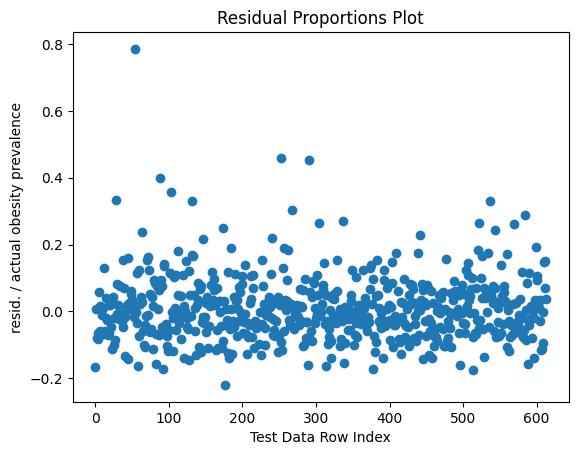

In [ ]:
y_res = (test_pred - y_test) / y_test
y_res.reset_index(inplace=True)

# Plot the results
plt.title("Residual Proportions Plot")
plt.xlabel("Test Data Row Index")
plt.ylabel("resid. / actual obesity prevalence")
plt.scatter(y_res.index, y_res['Percent_Person_Obesity'])
plt.show()


*Evaluation summary:* The model achieves a test MSE of approximately 10%. The residual plots provide insights into the model's error distribution.

How well does your model perform? We were able to achieve an MSE for the test set of approximately 10% points from the observed obesity prevalence. Our model was also able to fit the data with the residuals clustered between -20% and 30%, which for a simple model considering only three explanatory variables isn't so bad.

## 7. Conclusion and next steps
This notebook demonstrated the use of Data Commons to efficiently acquire data from multiple sources (CDC, BLS, Census) and build a simple linear regression model to predict obesity prevalence in US counties. Data Commons significantly streamlines the data gathering and integration process.

The resulting model, using high blood pressure prevalence, unemployment rate, and poverty rate, provides a baseline prediction.

**Potential improvements & further exploration:**

* Add More Variables: Incorporate other variables known or hypothesized to correlate with obesity, such as:
  * `Percent_Person_WithHighCholesterol`
  * `Percent_Person_WithDiabetes`
  * Educational attainment levels
  * Access to healthy food outlets
  * Physical inactivity rates
* **Feature engineering:** Create new features from existing ones.
* **Model selection:** Experiment with different regression models (e.g., Ridge, Lasso, tree-based models).
* **Geographic analysis:** Explore spatial patterns in obesity prevalence and model errors.
* **Alternative data sources:** Compare model performance using Census unemployment data instead of BLS data.
Data Commons provides access to a wide range of variables, enabling exploration of correlations with factors like university counts, crime rates (e.g., arson), or environmental factors (e.g., snowfall), potentially leading to more comprehensive models.